# SOFR curve builder
This script builds an interest rate curve using the implied rate of the SOFR 1 month futures.
The methodology is explained in the second report of the Alternative Reference Rates Committee (The Alternative Reference Rates Committee - SEC.gov https://www.sec.gov › arrc-second-report-041519)

The data are sourced from Yahoo finance and the New York Fed website.

The following packages are needed:
- pandas
- numpy
- datetime
- exchange_calendars
- calendar
- yfinance

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import exchange_calendars as xcal
import calendar
import yfinance

## Select the rate and the date
For the moment only SOFR is supported because all the necessary data is available without an expensive subscription, more can be added in the futures.txt supporting file.

In [3]:
arr="SOFR"
ref_date="22.03.2022"

In [4]:
futures_root= pd.read_table("futures.txt")

ref_date=dt.strptime(ref_date,"%d.%m.%Y")

#build the trading calendar
trading_cal=xcal.get_calendar(futures_root.loc[futures_root.ARR==arr]["CALENDAR"].to_list()[0],
                start=format(ref_date,"%Y-%m")+"-"+"01",
                end=str(ref_date.year+1)+"-"+str(ref_date.month)+"-"+str(calendar.monthrange(ref_date.year+1,ref_date.month)[1]))

In [5]:
# Build the future chain
monthcodes=pd.read_table("monthcodes.txt")
#concatenate future roots with month codes
future_codes=list()
for root in futures_root.loc[futures_root.ARR==arr]["FUTURE"].to_list():
    for monthcode in monthcodes["CODE"].to_list():
        future_codes.append(root+monthcode)
 
#add the year for the next 12 months        
future_codes=[x+str(ref_date.year%100)+".CME" for x in future_codes[ref_date.month-1:]]+[x+str(ref_date.year%100+1)+".CME" for x in future_codes[:ref_date.month-1]]
future_expiry=[str(x)+"-"+str(ref_date.year) for x in range(ref_date.month,12+1)]+[str(x)+"-"+str(ref_date.year+1) for x in range(1,ref_date.month)]
future_expiry=[str(trading_cal.closes[x].max().day)+"-"+x for x in future_expiry]
future_expiry=[dt.strptime(x,"%d-%m-%Y") for x in future_expiry]

In [6]:
#get the future prices from Yahoo finance and the SOFR time series from the NY Fed

def getFutPriceYahoo(x:str):
    ticker=yfinance.Ticker(x)
    tickerInfo=ticker.info
    price=(tickerInfo['bid']+tickerInfo['ask'])/2
    return price

future_prices=[getFutPriceYahoo(x) for x in future_codes]

future_rates=pd.DataFrame({"expiry":future_expiry,"rates":[100-x for x in future_prices]})

#download SOFR time series
sofr=pd.read_xml('https://markets.newyorkfed.org/read?startDt='+
                 format(ref_date,"%Y-%m")+'-01&endDt='+format(ref_date,"%Y-%m-%d")+
                 '&eventCodes=520&productCode=50&sort=postDt:-1,eventCode:1&format=xml',
                 xpath='.//rate')
sofr.index=pd.to_datetime(sofr["effectiveDate"])

In [7]:
future_prices

[99.83375,
 99.69749999999999,
 99.3125,
 99.045,
 98.80000000000001,
 98.49000000000001,
 98.3925,
 98.17,
 97.96000000000001,
 97.82749999999999,
 97.735,
 97.5925]

In [8]:
#compute the implied rate between the last known SOFR and the expiry of the first future
impliedRates=list()
for i,future in future_rates.iterrows():
    tradingDaysList=trading_cal.closes[format(future_rates["expiry"][i],"%Y-%m")]
    tradingDays=tradingDaysList.shape[0]
    daysWithSofr=sofr.loc[format(future_rates["expiry"][i],"%Y-%m")].shape[0]
    impliedRate=(future_rates["rates"][i]*tradingDays-sofr["percentRate"].mean()*daysWithSofr)/(tradingDays-daysWithSofr)
    thisImpliedRates=pd.DataFrame({"date":tradingDaysList,"rate":impliedRate})
    impliedRates.append(thisImpliedRates)
    
impliedRates=pd.concat(impliedRates)

In [11]:
# take the average n months ahead
dates=[(ref_date+pd.DateOffset(months=x)).to_period("D") for x in range(13)]
dates=[trading_cal.closes.loc[trading_cal.closes.index.to_period("D")<=x].max() for x in dates]
dates=[x.to_period("D") for x in dates]

average_rate=[impliedRates.rate.loc[(impliedRates.index.to_period("D")<=dates[x]) & 
                                    (impliedRates.index.to_period("D")>=dates[x-1])].mean() for x in range(1,len(dates))]

average_rate=np.array(average_rate)

#compute the term structure of annualized rates
term_rates=(((1+average_rate/100)**(1/12)).cumprod()**(12/np.array(range(1,13)))-1)*100
#add the known overnight rate
term_rates=np.append(np.array(sofr.loc[ref_date]["percentRate"]),term_rates)


,date,rate
date,,
2022-03-22,2022-03-22,0.280000
2022-04-22,2022-04-22,0.299332
2022-05-20,2022-05-20,0.438320
2022-06-22,2022-06-22,0.580623
2022-07-22,2022-07-22,0.716550
2022-08-22,2022-08-22,0.857933
2022-09-22,2022-09-22,0.977092
2022-10-21,2022-10-21,1.088453
2022-11-22,2022-11-22,1.198983


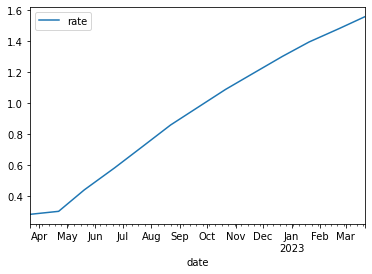

In [12]:
#and show it
term_structure=pd.DataFrame({"date":dates,"rate":term_rates})
term_structure.index=term_structure.date
term_structure.plot()
term_structure

The rates are around 2 bps lower than the term structure computed by the CME (which uses the 3 months futures as well and a different calculation methodology). Not bad indeed!

| Date       | 1 Month  | 3 Months | 6 Months | 1 Year  |
|------------|----------|----------|----------|---------|
| 22.03.2022 | 0.31668  | 0.60743  | 0.99369  | 1.57676 |
